In [2]:
# %reset -f
# Let's retrieve some data
# Working with PRL for now. Let's focus on PRL MB1 model
%load_ext autoreload
%autoreload 2
from path_settings import *
import joblib
from pathlib import Path
from importlib import reload
from agents import Agent
from tasks import akam_tasks as ts
from utils import *  # get_current_file_name, goto_root_dir
import pprint
import CustomMapper.CustomMapper as c
import torch
import pickle
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import torch.nn as nn
import time
from agents.DynamicSystems import ISNNet
from agents.ComplexAgent import DynamicAgent

pp = pprint.PrettyPrinter(indent=4, depth = 4)
goto_root_dir.run()
# LS0_data = joblib.load(SIM_SAVE_PATH / 'simulated_Akam_PRL' / 'LS0_seed0.pkl')

2025-07-24 18:04:18.669700: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-24 18:04:18.679761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-24 18:04:18.692458: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-24 18:04:18.692501: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-24 18:04:18.701299: I tensorflow/core/platform/cpu_feature_gua

In [3]:
%load_ext autoreload
%autoreload 2
from path_settings import *
from Network_models.Trainer import DynAgentTrainer
DynConfigs = {
    "model_name": "ISNNet",
    "save_path": MODEL_SAVE_PATH ,
    "check_path": MODEL_SAVE_PATH,
    "log_path": LOG_PATH,
    "optimizer_specs":{
        "optimizer_name": "Adam",
        "optimizer_params": {
            "lr": 0.001,
        },
    },
    "model_specs":{
        "model_name": "DynamicAgent", 
        "model_path": "agents.ComplexAgent",
        "model_params": {
            "net_type": "ISNNet", 
            "net_config": {},
            "trial_length": 1000, 
            "N": 10, 
            "out_dim": 1, 
            "in_dim": 3, 
            "hidden_dim": 32,
        }
    },
    "device": "cuda", 
    "scheduler": False, 
    # "scheduler": {
    #     "name": "ReduceLROnPlateau",
    #     "params": {
    #         "mode": "min",
    #         "factor": 0.1,
    #         "patience": 100,
    #         "min_lr": 5e-4,
    #         "cooldown": 50, 
    #     },
    # }, 
    "training_config": {
        "batch_size": 256, 
        "val_ratio": 0.2, 
        "n_trials": 100, 
    }, 
    "loss_config": {
        "loss_compound_func_package": "utils.loss_helpers", 
        "loss_compound_func": "interpolate_exp",
        "weight_regularisation_weight": 0.00, 
        "output_norm_weight": 0.00, 
        "input_norm_weight": 0.00
    }, 
    "task_module": "tasks.akam_tasks",
    "task": "Two_step_torch",
    "task_config": {
        "rew_gen": "blocks",
    }
}

trainer = DynAgentTrainer(DynConfigs)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
trainer.model.copy_C()
trainer.load_model(MODEL_SAVE_PATH / "ISNNet_I_on_5" / "model.pth")

In [4]:
trainer.model.eval()
trainer.task = getattr(trainer.task_module, trainer.config.get("task", "Two_step"))(**{"rew_gen": "walks"})
sample_size = 1000
with torch.no_grad():
    y, c, inp, x, out, y_raw = trainer.model.simulate(trainer.task, sample_size, 100, True, return_raw_out=True, noise_sd = 0.05)
    _, _, _, _, out_2 = trainer.model.simulate(trainer.task, sample_size, 100, True, True)
# plt.plot(x[0, :, 15].cpu().detach().numpy())
# plt.plot(y[0, :, 0].cpu().detach().numpy(), label = "p(y)")
# plt.plot(y_raw[0, :, 0].cpu().detach().numpy()/(max(y_raw[0, :, 0]) - min(y_raw[0, :, 0])).cpu().numpy(), label = "y raw") 

# plt.plot((i[0, :, 2].cpu().detach().numpy()) * 2, label = "I")
# plt.plot((i[0, :, 1].cpu().detach().numpy()) * 2, label = "S_S")

# plt.plot(c[0, :, 0].cpu().detach().numpy(), label = "correct choice")
# plt.legend(loc = "upper right")
print(f"score of the trained agent: {sum(sum(out.T))/100}")
print(f"score of the random agent: {sum(sum(out_2.T))/100}")

/home/timmy/projects/Tiny_RNN_RT/codes/Codes/agents/ComplexAgent.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  choice = torch.tensor(y[:, -2, 0] > 0.5, dtype=torch.float32, device=self.device)
/home/timmy/projects/Tiny_RNN_RT/codes/Codes/tasks/akam_tasks.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transition = torch.tensor(
/home/timmy/projects/Tiny_RNN_RT/codes/Codes/tasks/akam_tasks.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  second_step = torch.tensor(
/home/timmy/projects/Tiny_RNN_RT/codes/Codes/tasks/akam_t

score of the trained agent: 534.4099731445312
score of the random agent: 501.4700012207031


In [4]:
# let's now convert these model results into training data useful for the RTRNNs 
import pandas as pd 
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
ndt_mu = 300
ndt_s = 50 # these are all in ms
t_a = 0
t_b = 3
# lets say each trial is of 1500 ms, and in the model we only record activity from decision times
def convert_trials(y_raw, ndt_mu, ndt_s): 
    """we assign RT based on model output, which is discretised into 10 steps per trial and now stored in y_raw:

    Args: 
        y_raw (torch.tensor): model output, of shape (batch_size, seq_len, N)
    """
    # the logic is, based on the raw decision output curve sample a reaction time at which the decision is made. 
    # the decision should additionally be coherent to the last time step's decision. 
    # record 1 if the decision is from a positive y_raw, 0 otherwise
    # base this on standard deviations of all decision values
    batch_size, n_trials, N = y_raw.shape
    y_std = torch.std(y_raw)
    rt = torch.randn(batch_size, n_trials, device=y_raw.device) * ndt_s + ndt_mu
    choices = torch.zeros(batch_size, n_trials, device=y_raw.device)
    for i in range(batch_size):
        for j in range(n_trials):
            y_N = y_raw[i, j, :]
            choices[i, j] = 1 if y_N[-1] > 0 else 0
            for k in range(N):
                if torch.rand(1, device=y_raw.device) < abs(y_N[k])/y_std and torch.sign(y_N[k]) == torch.sign(y_N[-1]):
                    rt[i, j] += k * 1300/N
                    break
                if k == N - 1: 
                    rt[i, j] = torch.nan
            
    return (rt, choices)

def convert_inputs(input_raw, N = 10, seq_len = 100): 
    # Input raw is in the form of (batch_size, seq_len, 3) where the 3 are past_choice, reward, and second_stage
    input_raw = input_raw.reshape(-1, seq_len, N, 3).cpu().numpy()
    past_choice = []
    reward = []
    stage2 = []
    block = []
    for i in range(input_raw.shape[0]):
        for j in range(seq_len):
            past_choice.append(np.array(input_raw[i, j, 0, 0]>0, dtype = int))
            reward.append(np.array(input_raw[i, j, 0, 1]>0, dtype = int))
            stage2.append(np.array(input_raw[i, j, 0, 2]>0, dtype = int))
            block.append(i)
    cog_data = pd.DataFrame({"action": past_choice, "reward": reward, "stage2": stage2, "block": block})
    return cog_data

def get_dataloaders(cog_data, rt, choices, batch_size, device = "cuda", K_folds = 1, shuffle=True):
    input_data = np.zeros([rt.shape[0], rt.shape[1], 6])
    choice_data = np.zeros([rt.shape[0], rt.shape[1], 2])
    for i in range(rt.shape[0]):
        # input_data[i, :, 0] = np.concatenate((np.array([0]), np.array(cog_data["action"][cog_data.block == i])[:-1] == 0))
        # input_data[i, :, 1] = np.concatenate((np.array([0]), np.array(cog_data["action"][cog_data.block == i])[:-1] == 1))
        # input_data[i, :, 2] = np.concatenate((np.array([0]), np.array(cog_data["reward"][cog_data.block == i])[:-1] == 0))
        # input_data[i, :, 3] = np.concatenate((np.array([0]), np.array(cog_data["reward"][cog_data.block == i])[:-1] == 1))
        # input_data[i, :, 4] = np.concatenate((np.array([0]), np.array(cog_data["stage2"][cog_data.block == i])[:-1] == 0))
        # input_data[i, :, 5] = np.concatenate((np.array([0]), np.array(cog_data["stage2"][cog_data.block == i])[:-1] == 1))
        input_data[i, :, 0] = np.array(cog_data["action"][cog_data.block == i]) == 0
        input_data[i, :, 1] = np.array(cog_data["action"][cog_data.block == i]) == 1
        input_data[i, :, 2] = np.array(cog_data["reward"][cog_data.block == i]) == 0
        input_data[i, :, 3] = np.array(cog_data["reward"][cog_data.block == i]) == 1
        input_data[i, :, 4] = np.array(cog_data["stage2"][cog_data.block == i]) == 0
        input_data[i, :, 5] = np.array(cog_data["stage2"][cog_data.block == i]) == 1

    choice_data[:, :, 0] = choices.cpu().numpy()
    choice_data[:, :, 1] = rt.cpu().numpy()
    train_dataset = CustomDataset(input_data[:int(0.8 * len(input_data)), ...], choice_data[:int(0.8 * len(choice_data)), ...], device = device)
    val_dataset = CustomDataset(input_data[int(0.8 * len(input_data)):, ...], choice_data[int(0.8 * len(choice_data)):, ...], device = device)
    # do K folds: 
    if K_folds > 1: 
        kf = KFold(n_splits=K_folds, shuffle = shuffle)
        splits = []
        for train_index, val_index in kf.split(input_data):
            train_dataset = CustomDataset(input_data[train_index, ...], choice_data[train_index, ...], device = device)
            val_dataset = CustomDataset(input_data[val_index, ...], choice_data[val_index, ...], device = device)
            splits.append((train_dataset, val_dataset))

        dataloaders = []
        for train_dataset, val_dataset in splits:
            dataloaders.append({
                "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle),
                "val": DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
            })
        return dataloaders
    else: 
        return {
            "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle),
            "val": DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
        }

class CustomDataset(Dataset):
    def __init__(self, u, x, device = None):
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.x = torch.tensor(x, device = device)
        self.u = torch.tensor(u, device = device)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.u[idx], self.x[idx]


In [5]:
from Network_models.Trainer import RTRNNTrainer

In [7]:
# RTRNN training on the data!
batch_size = 20
out_distribution = False
configs = {
    "save_path": MODEL_SAVE_PATH ,
    "check_path": MODEL_SAVE_PATH,
    "log_path": LOG_PATH,
    "optimizer_specs":{
        "optimizer_name": "Adam",
        "optimizer_params": {
            "lr": 0.001,
        },
    },
    "model_specs":{
        "model_name": "RTRNN", 
        "model_path": "Network_models.RTRNN",
        "model_params":{
            "batch_size": batch_size, "input_size": 6, "output_size": 2, "hidden_size": 16, "recurrence_per_trial": 2,
            "cell_type":"GRU", "trial_output_hidden": 1, "trial_output_hidden_size": [16,], # if want hidden output layers (deep output, then give a list)
            "trial_output_hidden_nonlinearities": ["ReLU"], 
            "last_step": False, # use only the last step of the decision RNN trajectory per trial
            "pad_zeros":0, # i .* [1, 0, ,...] (if pad_zeros) or [1, 1, 1,...] 
            "trial_interpolation": True,  # add an additional input channel indicating a 0 to 1 linspace for each trial
            "noisy": False, # add noise to hidden states
            "out_distribution": out_distribution, # output a parametrization of the distribution of the choice and RT as a mixed Gaussian (for now) and note the tau length scale is defined in the loss function.  
        },
    },
    "rt_dist_specs": {
        "dist_name": 'gaussian' if out_distribution else None,
    }, 
    "rt_weight" : 0.01, 
    "device": "cuda", 
    # "scheduler": False, 
    "scheduler": {
        "name": "ReduceLROnPlateau",
        "params": {
            "mode": "min",
            "factor": 0.1,
            "patience": 100,
            "min_lr": 5e-4,
            "cooldown": 50, 
        },
    }, 
    "training_config": {
        "batch_size": 256, 
        "val_ratio": 0.2, 
        "n_trials": 10, 
    }, 
}
rtrnn_trainer = RTRNNTrainer(configs)


In [6]:
# y_raw = y_raw.reshape(y_raw.shape[0], -1, trainer.model.N)
# rt, choices = convert_trials(y_raw, ndt_mu, ndt_s)
# rt = rt/1500
# y_raw = y_raw.reshape(y_raw.shape[0], -1, 1)
# cog_data = convert_inputs(inp)
# dataloaders_train = get_dataloaders(cog_data, rt, choices, batch_size, device = "cuda", K_folds = 5)
dataloaders_train = torch.load(MODEL_SAVE_PATH/ "dataloaders.pth")

In [7]:
class RTSeriesDataset(Dataset):
    """
    Convert (u, x) → (recording, stimulus_type, stimulus_onehot).

    u : (B, T_trials, D_in)  -- one–hot [stim, action-1, reward-1] @ trial resolution
    x : (B, T_trials, 2)     -- (choice ∈{0,1},  RT in seconds)

    recording        : (B, Trial number, 1)
                       inactivity  → 0  
                       choose left → 1 
                       choose right→ 2

    stimulus_type    : (B, Trial number, 1)
                       integer index 0…S, copied across the micro-steps of the trial
                       NOTE: count S + 1 types of stimuli; 
                       the S of which enumerates the stimulus type, another one is 
                       the grounding signal at choice commitment

    stimulus_onehot  : (B, Trial number, log_2(S) + 1)
                       same info but one-hot (optional inductive-bias version, constructing the K from stim)
    """
    def __init__(self, u, x, dt=0.1, max_rt=3.0,
                 keep_onehot=True, device=None):
        super().__init__()
        self.u = u.to(device) if device else u          # (B, T_trials, D_in)
        self.x = x.to(device) if device else x          # (B, T_trials, 2)
        if torch.isnan(self.x).any():
            print("Warning: NaN values found in x, replacing with 1.5")
            self.x = torch.nan_to_num(self.x, nan=max_rt)
        self.dt       = dt                              # micro-time step in seconds
        self.keep_onehot = keep_onehot
        
        # ── pre-compute the stimulus channels inside u ─────────────────
        # assume u = [stim_onehot | action-1 onehot | reward-1 onehot]
        self.s = 2 * self.u[..., :].sum(dim=-1).max().int().item() # types of stimuli (in which we have 0 or 1)
        self.S = int(2 ** (self.s / 2))  # number of stimulus types
        self.s_list = torch.tensor([2 ** ((self.s/2) - i - 1) for i in range(int(self.s/2))], dtype = torch.double).to(self.u.device)  # list of powers of 2 for each stimulus type
        self.T_micro = np.ceil(max_rt / self.dt)  # fixed per-trial canvas upper bound
        self.stim_slice = slice(0, self.s, 2)

    def __len__(self):
        return self.u.size(0)   # batch dimension exposed to DataLoader

    def __getitem__(self, idx):
        u_i = self.u[idx]                    # (T_trials, D_in)
        x_i = self.x[idx]                    # (T_trials, 2)

        rec_list, stim_type_list, stim_1h_list = [], [], []
        for t in range(u_i.size(0)):
            choice  = int(x_i[t, 0].item())        # 0 or 1
            rt_sec  = float(x_i[t, 1].item())
            n_steps = min(int(torch.ceil(torch.tensor(rt_sec / self.dt))),
                          self.T_micro)

            # ----- recording -----
            # rec_trial = torch.zeros(self.T_micro, 2, device=u_i.device)
            rec_trial = torch.zeros(n_steps + 1, device=u_i.device)
            if n_steps > 0:
                rec_trial[n_steps-1] = choice + 1
            rec_list.append(rec_trial)

            # ----- stimulus type (index) -----
            # stim_vec = u_i[t, self.stim_slice]                     # one-hot

            # stim_idx = int(torch.argmax(stim_vec).item())          # 0 … S-1
            stim_vec = u_i[t, self.stim_slice]
            stim_idx = stim_vec @ self.s_list  # compute the index as a dot product with powers of 2

            stim_type = torch.full((n_steps + 1, 1),
                                   stim_idx,
                                   dtype=torch.long,
                                   device=u_i.device)
            stim_type[-1] = self.S  # last step is the grounding signal
            stim_type = stim_type.squeeze(-1)
            stim_type_list.append(stim_type)

            if self.keep_onehot:
                stim_vec = torch.cat((stim_vec, torch.zeros(1, device=u_i.device)))  # add grounding signal
                stim_1h = stim_vec.unsqueeze(0).repeat(n_steps + 1, 1)
                stim_1h[-1, :] = torch.zeros_like(stim_1h[-1, :])  # last step is the grounding signal
                stim_1h[-1, -1] = 1.0  # last step is the grounding signal
                stim_1h_list.append(stim_1h)

        recording      = torch.cat(rec_list,       dim=0)  # (T_trials*T_micro, 2)
        stimulus_type  = torch.cat(stim_type_list, dim=0)  # (.., 1)
        out = {
            "recording":      recording,
            "stimulus_type":  stimulus_type,
        }
        if self.keep_onehot:
            stimulus = torch.cat(stim_1h_list, dim=0)      # (.., S)
            out["stimulus"] = stimulus

        return out

In [15]:
class PaddedRTSeriesDataset(Dataset):
    """
    Each sample holds one *sequence* (subject / session) with all trials
    padded so that DataLoader can batch without a custom collate_fn.

    recording      : (seq_len * T_micro, 2)      -- one-hot response stream
    stimulus_type  : (seq_len * T_micro, 1)      -- int index 0…S-1
    stimulus_1h    : (seq_len * T_micro, S)      -- optional one-hot
    mask           : (seq_len * T_micro,)        -- 1 = real step, 0 = pad
    """

    def __init__(self, u, x,
                 dt=0.01,              # micro step (s)
                 rt_ceiling=None,      # if None infer from data
                 keep_onehot=True,
                 device=None):
        """
        u : Tensor (B, T_trials, D_in)  -- one-hot [stim, a_{t-1}, r_{t-1}]
        x : Tensor (B, T_trials, 2)     -- (choice, rt)
        """
        super().__init__()
        self.u = u.to(device) if device else u
        self.x = x.to(device) if device else x
        if torch.isnan(self.x).any():
            print("Warning: NaN values found in x, replacing with 1.5")
            self.x = torch.nan_to_num(self.x, nan=rt_ceiling)
        self.keep_onehot = keep_onehot
        self.dt = dt

        # —— determine global micro canvas ————————————————
        if rt_ceiling is None:
            rt_ceiling = x[..., 1].max().item()   # seconds
        self.T_micro = int(torch.ceil(torch.tensor(rt_ceiling / dt)))
        # —— pre-compute stimulus split ————————————————
        # assume first S dims of u are stimulus one-hot
        self.s = (self.u[..., :].sum(-1).max().int().item()) * 2
        self.S = int(2 ** (self.s / 2))  # number of stimulus types
        self.s_list = torch.tensor([2 ** ((self.s/2) - i - 1) for i in range(int(self.s/2))], dtype = torch.double).to(self.u.device)  # list of powers of 2 for each stimulus type

        self.stim_slice = slice(0, self.s, 2)

    def __len__(self):
        return self.u.size(0)            # one sample = one sequence

    def __getitem__(self, idx: int):
        u_i = self.u[idx]                # (T_trials, D_in)
        x_i = self.x[idx]                # (T_trials, 2)
        T_trials = u_i.size(0)

        # pre-allocate padded tensors
        steps_per_seq = T_trials * (self.T_micro + 1)
        rec      = torch.zeros(steps_per_seq, 1,  device=u_i.device)
        stim_idx = torch.zeros(steps_per_seq, 1,  dtype=torch.long,
                               device=u_i.device)
        if self.keep_onehot:
            stim_1h = torch.zeros(steps_per_seq, self.s // 2, device=u_i.device)
        mask     = torch.zeros(steps_per_seq,    device=u_i.device)

        cursor = 0
        for t in range(T_trials):
            choice = int(x_i[t, 0].item())            # 0 or 1
            rt     = float(x_i[t, 1].item())
            n_real = min(int(torch.ceil(torch.tensor(rt / self.dt))),
                         self.T_micro)                # cap at canvas

            # slice for this trial
            seg = slice(cursor, cursor + self.T_micro + 1)

            # ----- recording -----
            if n_real > 0:
                rec[seg][n_real-1] = choice + 1      # commit step
            # ‘inactivity’ steps already 0

            # ----- stimulus -----
            stim_vec = u_i[t, self.stim_slice]        # one-hot
            s_idx    = stim_vec @ self.s_list
            
            
            stim_idx[seg][0:n_real] = s_idx
            stim_idx[seg][n_real] = self.S
            if self.keep_onehot:
                stim_1h[seg][0:n_real, :] = stim_vec               # broadcast
                stim_1h[seg][n_real, :] = torch.zeros_like(stim_1h[seg][n_real, :])  # last step is the grounding signal
                stim_1h[seg][n_real, -1] = 1.0

            # ----- legality mask -----
            mask[seg][:n_real + 1] = 1.0

            cursor += self.T_micro + 1

        sample = {
            "recording":      rec.squeeze(-1),            # (L,)
            "stimulus_type":  stim_idx.squeeze(-1),       # (L,)
            "mask":           mask,           # (L,)
        }
        if self.keep_onehot:
            sample["stimulus"] = stim_1h      # (L, S)
        return sample
fake_rt = torch.ones_like(dataloaders_train[0]['train'].dataset.x[..., 1]) * 1.5
x = torch.cat((dataloaders_train[0]['train'].dataset.x[..., 0:1], fake_rt.unsqueeze(-1)), dim=-1)  # (B, T_trials, 2)
dataset  = PaddedRTSeriesDataset(
                                u=dataloaders_train[0]['train'].dataset.u,
                                x=dataloaders_train[0]['train'].dataset.x,
                                # x = x,
                                dt=0.1,  # micro-time step in seconds
                                rt_ceiling=1.5,
                                keep_onehot=True)
loader   = torch.utils.data.DataLoader(dataset,
                                       batch_size=64,
                                       shuffle=True)
batch = next(iter(loader))
recording      = batch["recording"]      # (B, L, 1)
stim_type      = batch["stimulus_type"]  # (B, L, 1)
stimulus_1h    = batch["stimulus"]       # (B, L, S)
mask           = batch["mask"]           # (B, L)

(array([1.9045e+04, 3.0159e+04, 7.9800e+03, 4.5520e+03, 3.5940e+03,
        3.6180e+03, 2.7010e+03, 1.4000e+01, 0.0000e+00, 8.3370e+03]),
 array([0.05296553, 0.19766897, 0.34237242, 0.48707587, 0.63177932,
        0.77648276, 0.92118621, 1.06588966, 1.21059311, 1.35529655,
        1.5       ]),
 <BarContainer object of 10 artists>)

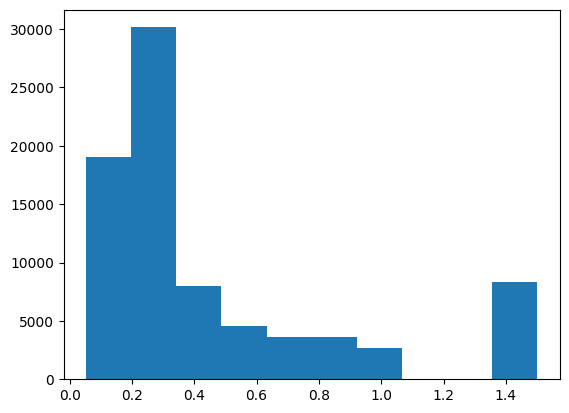

In [9]:
plt.hist(torch.nan_to_num(dataloaders_train[0]['train'].dataset.x[:, :, 1], nan=1.5).cpu().flatten().numpy())
# plt.hist(x[:, :, 1].cpu().flatten().numpy(), bins=50)

In [62]:
from Network_models.HMMModels import HMMModel_linearK


In [66]:
K = 16
stim_bits = 3
model = HMMModel_linearK(z_dim = K, stim_types=stim_bits)
# model.load_checkpoint(MODEL_SAVE_PATH / "HMMModel_linearK" / "best_epoch_no_rt.pth")
model.get_params()
model.to("cuda")
ll_seq = []
epochs = 16
best_ll = -np.inf
model.train()
for epoch in range(epochs): 
    ll_loc = torch.zeros(len(loader))

    for i, train_set in enumerate(loader):
        recording = train_set["recording"].to("cuda")
        stim_type = train_set["stimulus_type"].to("cuda")
        mask = train_set["mask"].to("cuda")
        
        ll = model.fit_batch(stim_type, recording, mask.long())
        print(f"train_set {i+1}/{len(loader)}, log-lik={ll.mean().item():.3f}")
        if ll.mean().item() > best_ll: 
            best_ll = ll.mean().item()
            model.save_checkpoint(MODEL_SAVE_PATH / "HMMModel_linearK" / f"best_epoch.pth")
 
        ll_loc[i] = ll.mean().item()
    ll_seq.append(ll_loc.mean().item())
   
    # K_seq.append(model.K[0].cpu().detach().numpy())
    # P_seq.append(model.P.cpu().detach().numpy())
    # pi_seq.append(model.pi.cpu().detach().numpy())
    print(f"Epoch {epoch+1}/{epochs}, log-lik={ll_loc.mean().item():.3f}")
model.eval() 

train_set 1/13, log-lik=-528.357
train_set 2/13, log-lik=-342.981
train_set 3/13, log-lik=-343.767
train_set 4/13, log-lik=-336.721
train_set 5/13, log-lik=-331.493
train_set 6/13, log-lik=-342.018
train_set 7/13, log-lik=-343.958
train_set 8/13, log-lik=-341.547
train_set 9/13, log-lik=-340.264
train_set 10/13, log-lik=-338.310
train_set 11/13, log-lik=-341.788
train_set 12/13, log-lik=-341.151
train_set 13/13, log-lik=-340.266
Epoch 1/16, log-lik=-354.817
train_set 1/13, log-lik=-342.121
train_set 2/13, log-lik=-340.148
train_set 3/13, log-lik=-340.383
train_set 4/13, log-lik=-338.435
train_set 5/13, log-lik=-343.012
train_set 6/13, log-lik=-340.275
train_set 7/13, log-lik=-340.173
train_set 8/13, log-lik=-342.128
train_set 9/13, log-lik=-342.211


KeyboardInterrupt: 

In [ ]:
model.load_checkpoint(MODEL_SAVE_PATH / "HMMModel_linearK" / "best_epoch.pth")

In [72]:
model.save_checkpoint(MODEL_SAVE_PATH / "HMMModel_linearK" / "best_epoch_with_rt.pth")

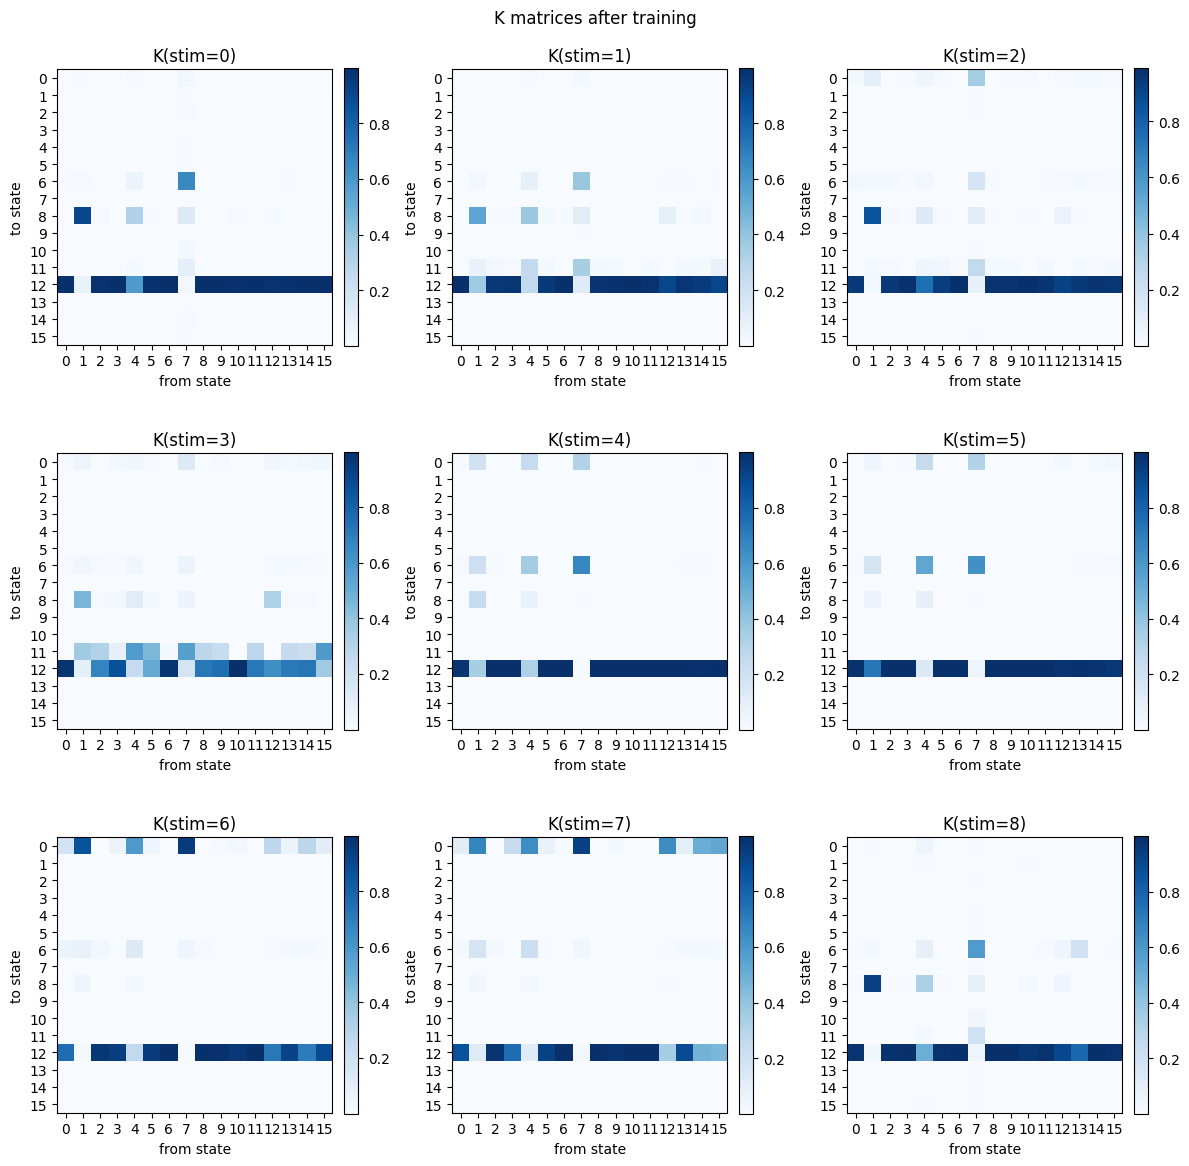

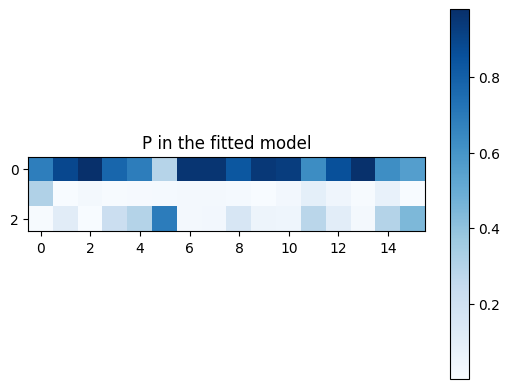

In [28]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for stim in range(9):
    ax = axes[stim // 3, stim % 3]
    im = ax.imshow(model.K[stim].cpu().detach(), cmap="Blues", origin="upper")
    ax.set_title(f"K(stim={stim})")
    ax.set_xlabel("from state")
    ax.set_ylabel("to state")
    ax.set_xticks(range(model.K.shape[2]))
    ax.set_yticks(range(model.K.shape[1]))
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.suptitle("K matrices after training")
plt.tight_layout()
plt.show()
plt.imshow(model.P.T.cpu().detach(), cmap="Blues", origin="upper")
plt.title("P in the fitted model"); plt.colorbar(); plt.show()


In [48]:
with torch.no_grad():
    lalpha = model.predictive_forward(stim_type, recording, mask.long())

In [49]:
lalpha_ = lalpha - lalpha.min(dim=-1, keepdim=True).values
alpha = torch.exp(lalpha_)
alpha = alpha / alpha.sum(dim=-1, keepdim=True)

In [50]:
expected_choice = (alpha @ model.P) @ torch.tensor([0, -1, 1], device = alpha.device).float()

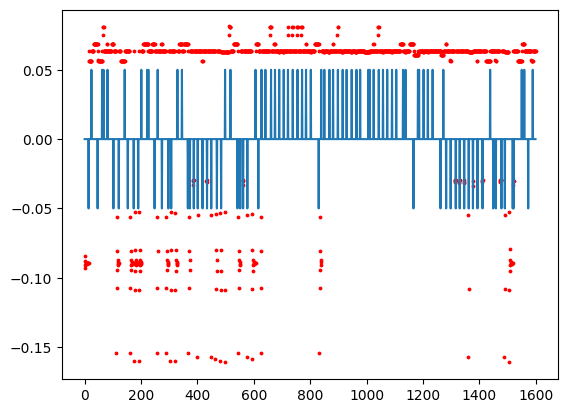

In [60]:
index = 8
plotted= 1600
plt.plot(0.1 * (recording - 1.5 * (recording != 0))[index, :plotted].cpu().detach().numpy(), label = "recording")
x = torch.arange(0, recording.shape[1])[:plotted]
plt.scatter(x, expected_choice[index, :plotted].cpu().detach().numpy(), label = "pred", color = "red", s = 3)

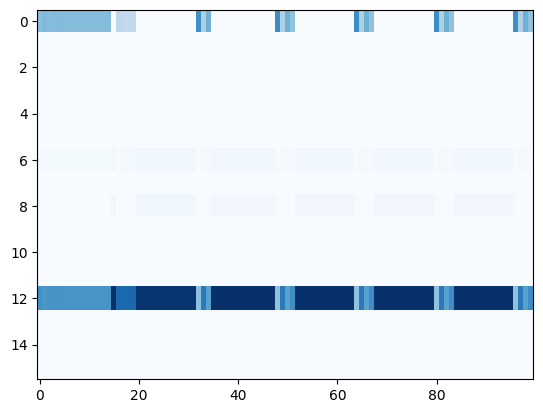

In [54]:
plt.imshow(alpha[1][:plotted, :].T.cpu().detach().numpy(), aspect='auto', cmap='Blues', interpolation="nearest")

In [40]:
alpha[9, 14, 0]

tensor(0.8598, device='cuda:0')

In [57]:
stim_type[1, 18]

tensor(6, device='cuda:0')